In [ ]:
# Download survival package
devtools::install_github("kassambara/survminer", build_vignettes = FALSE, upgrade = "never", lib="/kaggle/working")


Read data 

In [ ]:
# Read in data
blp = readRDS("../input/blp.multiple.rds")

Inspect data set

In [ ]:
# overview
head(blp)
# number of nouns
length(unique(blp$word))
# number of nouns that are singlar
length(blp$word[blp$number == 'singular'])
# .. plural
length(blp$word[blp$number == 'plural'])

Fit a Cox proportional hazards model with log.frequency, length, and number as predictors to the data

In [ ]:
# Load libraries
library(survival)
install.packages("survminer")
library(survminer)

In [ ]:
# Fit Cox proportional hazards model
cox.mult = coxph(Surv(rt,status) ~ log.frequency + length + number,
                 data = blp)

# statistical test
summary(cox.mult)

** **Reject the null hypothesis that none of the predictors has an influence on the hazard rate for a word.**<br>
The model summary reports the results of three statistical tests of the null hypothesis for the model as a whole: the likelihood ratio test, the Wald test, and the logrank test. The p-values for the corresponding test statistics are extremely small. We therefore reject the null hypothesis and accept the alternative hypothesis that at least one of the predictors (log) frequency, word lengh, and number has a significant effect on the shape of the hazard function in the word naming task.

* **All three of the predictors have a significant effect on the hazard rate.**<br>
The p-values for (log) frequency, word length, and number are all extremely small. We therefore reject the null hypothesis for each predictor and accept the alternative hypothesis that the coefficient of the predictor is not zero. The results of the Cox proportional hazards model thus indicate that word frequency, word length, and number all have a significant effect on the shape of the hazard function.

* **Harzard rates are higher for plural nouns.**
The coefficient of numbersingular is no-show, while that os numberplural is positive, as the numbersingular is the reference level here.
* **At any point in time, the ratio of the hazard rates for plurals and singulars is 1.3436.**



Generate survival curves for the 0.10, 0.25, 0.50, 0.75,and 0.90 quantiles of the word frequency distribution, for word length, and for singulars and plurals.

In [ ]:
# Create data frame for predictions
newdata.freq.singular = data.frame(
  "log.frequency" = quantile(blp$log.frequency,
                             c(0.1, 0.25, 0.5, 0.75, 0.9)),
  "length" = mean(blp$length),
"number" = "singular" )

# Inspect data frame
newdata.freq.singular

In [ ]:
# Create data frame for predictions
newdata.freq.plural = data.frame(
  "log.frequency" = quantile(blp$log.frequency,
                             c(0.1, 0.25, 0.5, 0.75, 0.9)),
  "length" = mean(blp$length),
"number" = "plural" )

# Inspect data frame
newdata.freq.plural

Make separate plots the survival curve estimates for the selected quantiles of the word frequency distribution, for the selected quantiles of the word length distribution, and for singulars and plurals.

* **selected quantiles of the word frequency distribution**

In [ ]:
# Create data frame for predictions
newdata.freq = data.frame(
  "log.frequency" = quantile(blp$log.frequency,
                             c(0.1, 0.25, 0.5, 0.75, 0.9)),
  "length" = mean(blp$length),
"number" = 'singular')

surv.freq = survfit(cox.mult, newdata = newdata.freq)

In [ ]:
# Create summary of survival curves
surv.freq.sum = surv_summary(surv.freq)
# Define columns of interest
cols = c("time", "surv", "upper", "lower", "strata")
# Plot survival curves
plot(surv.freq, xlab = "time (ms)", ylab = "S(t)",
     col = c("#00a37a", "#000aa3", "#a30000", "#9ea300", "#a300a3"))

The survival curves are distinguishable. <br>
Throughout the response time window, survival probabilities are higher for words with higher frequency.

* **selected quantiles of the word length**

In [ ]:
# Create data frame for predictions
newdata.len = data.frame(
  "length" = quantile(blp$length,
                             c(0.1, 0.25, 0.5, 0.75, 0.9)),
  "log.frequency" = mean(blp$log.frequency),
"number" = 'singular')

surv.len = survfit(cox.mult, newdata = newdata.len)

In [ ]:
# Create summary of survival curves
surv.len.sum = surv_summary(surv.len)
# Define columns of interest
cols = c("time", "surv", "upper", "lower", "strata")
# Plot survival curves
plot(surv.len, xlab = "time (ms)", ylab = "S(t)",
     col = c("#00a37a", "#000aa3", "#a30000", "#9ea300", "#a300a3"))

The survival curves are hardly distiguishable.<br>


* **singulars vs. plurals**

In [ ]:
# Create data frame for predictions
newdata.num = data.frame(
  "number" = c('singular', 'plural'),
  "log.frequency" = mean(blp$log.frequency),
"length" = mean(blp$length))

surv.num = survfit(cox.mult, newdata = newdata.num)

In [ ]:
# Create summary of survival curves
surv.num.sum = surv_summary(surv.num)
# Define columns of interest
cols = c("time", "surv", "upper", "lower", "strata")
# Plot survival curves
plot(surv.len, xlab = "time (ms)", ylab = "S(t)",
     col = c("#00a37a", "#000aa3"))

The survival curves are hardly distiguishable.<br>


*The predictor log.frequency has the strongest influence on the shape of the survival function.*

Test if the proportional hazards assumption holds true for the model as a whole, as well as for the individual predictors.

In [ ]:
# Check proportional hazards assumption
cox.zph.mult = cox.zph(cox.mult)
# Inspect results
cox.zph.mult

The p-values in the output of the cox.zph() function provide information about the probability that the proportional hazards assumption holds true for each of the predictors that were entered into the model, as well as for the model as a whole. <br>
The p-values for the predictors (log) frequency, word length are extremely small, as is the p-value for the model as a whole(GLOBAL). We therefore reject the null hypothesis that hazard ratios are constant over time for each predictor, as well as for the model as a whole.<br>
The p-value for the predictor number is not small enough comparing to the other predctors, we may accept the null hypothesis for this predictor.

Make a plot of the Schoenfeld residuals for each predictor as well.

In [ ]:
# Plot Schoenfeld residuals
plot(cox.zph.mult, resid = FALSE, xlab = "time (ms)", ylab = "beta(t)")

The Schoenfeld residuals are not constant over time, neither for word frequency, nor for word length, nor for number. We conclude that the Cox proportional hazards model does not accurately capture the influence of the frequency of a word, the length of a word in letters, and the number of a word on the shape of the hazard function.

Fit an Aalen additive hazards model to the data, again including (log) frequency, word length, and number as predictors.

In [ ]:
# Fit Aalen additive hazards model to the data
aareg.mult = aareg(Surv(rt,status) ~ log.frequency + length + number,
                   data = blp)

# Show summary
aareg.mult

* **chisq test**<br>
The null hypothesis for the chi-square test of the model as a whole is that none of the predictors influences the shape of the hazard function. The test statistic χ2 (chi-square) is  large and the corresponding p-value is very small. We therefore reject the null hypothesis and conclude that at least one of the predictor (log) frequency, word length, and number influences the shape of the hazard function.

* **numerical predictors**<br>
The statistical tests for the predictor effects provide information about the contribution of the individual predictors. Both (log) frequency and word length have a strongly significant effect on the hazard rate. The value of the column “slope” provides an overall estimate of the qualitative nature of a predictor effect. The positive value of “slope” for (log) frequency indicates that on average hazard rates are higher for high frequency words. By contrast, the negative value of “slope” for word length suggests that on average hazard rates are lower for longer words.

* **categorical predictor**<br>
As was the case for the Cox proportional hazards model, the effect of the categorical number is reported through contrasts with the reference level numbersingular. The low p-value for the corresponding term in the model summary indicates that we have enough evidence to conclude that the hazard curves for numberplural are not identical to the hazard curve for numbersingular. Hazard rates are higher for numberplural compared to numbersingular, which is the reference level.

Plot cumulative coefficient curve.

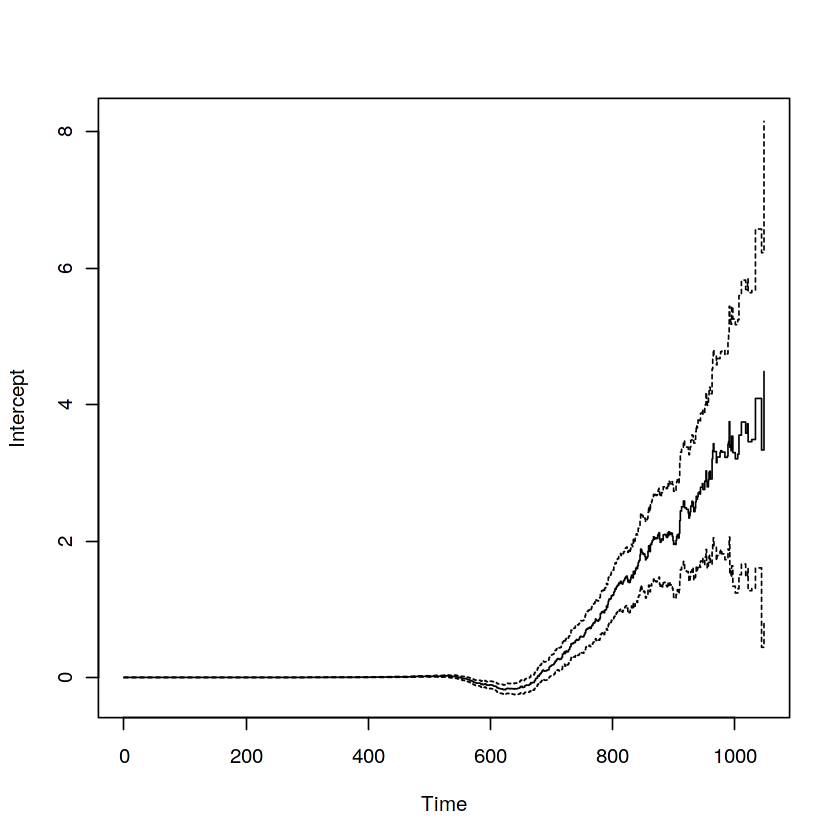

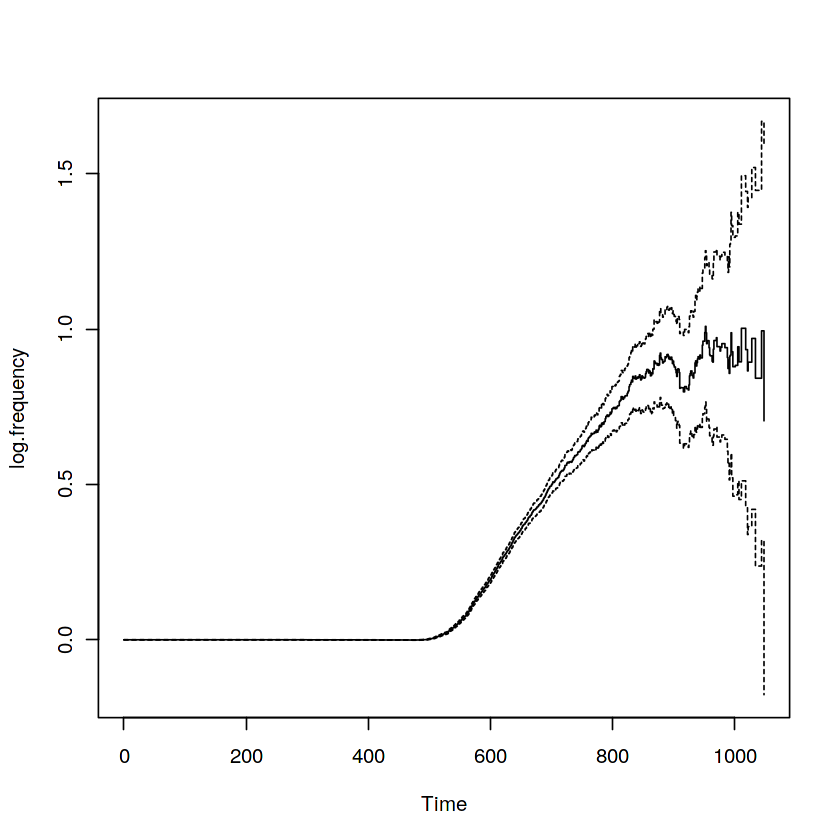

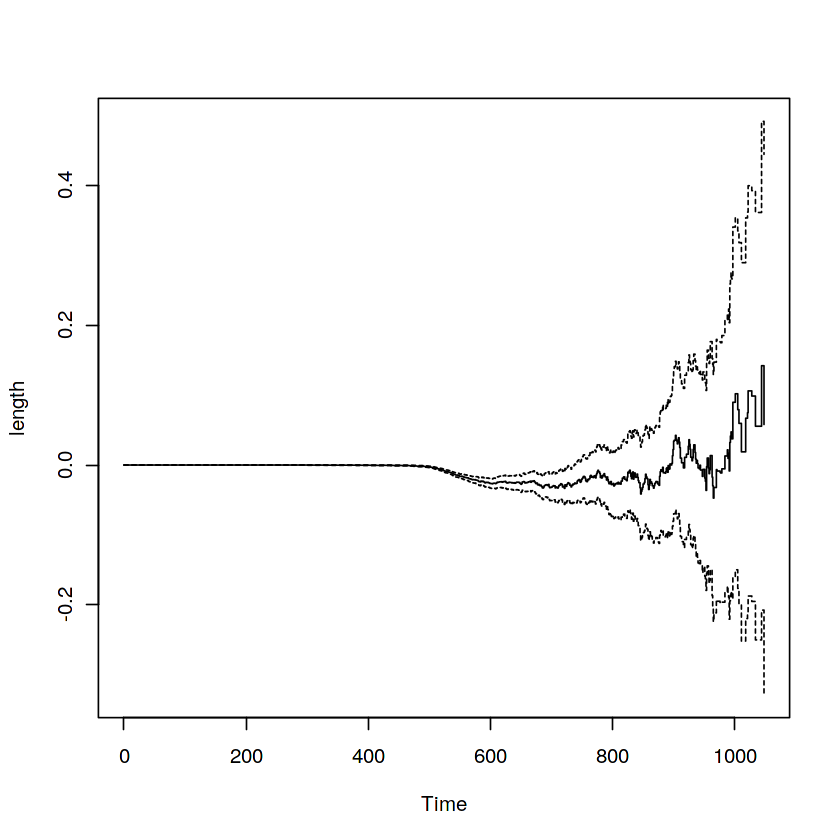

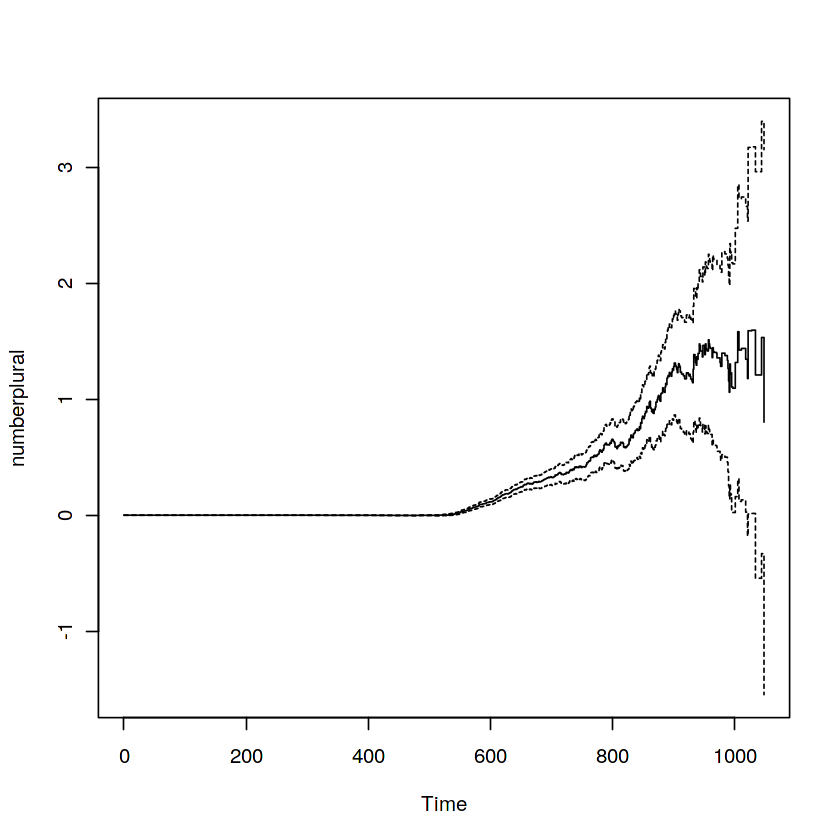

In [37]:
# Cumulative hazard plot
plot(aareg.mult)

* **The curve for the cumulative coefficient for (log) frequency is convex in nature.**


* **The curve for the cumulative coefficient of word length is convex in nature.** <br>
During the initial stages of the response time window, the cumulative hazard function decreases. Given that the slope of the cumulative hazard function is the value of the hazard function, hazard rates thus are lower for longer words. The initial decrease in the cumulative coeffi- cient drives the overall nature of the word length effect in the Cox proportional hazards model.During the later stages of the response time window, however, the adjustment to the cumulative hazard function for word length increases. During these stages of the response time window, hazard rates thus are higher for longer words.

* **The cumulative coefficient of numberplural is positive through the response time window**